# Packages required

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import glob
import cv2
import ujson as json
#import json
from collections import OrderedDict
from collections import Counter

import seaborn as sns
import math
import datetime
from collections import defaultdict


In [2]:
## Sklearn stuff
#from sklearn.model_selection import StratifiedKFold
from math import sqrt
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_curve, auc #roc_auc_score as AUC

In [3]:
## Keras stuffs
from keras import __version__ as keras_version
print('Keras version: {}'.format(keras_version))
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D, ZeroPadding1D, AtrousConvolution1D, MaxPooling1D, AveragePooling1D,GlobalAveragePooling1D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.optimizers import SGD,Adam
from keras import backend as K
from keras.preprocessing import image
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


Keras version: 1.2.2


In [4]:
## our functions
from ipinyouReader import * #name overlap
import ipinyouWriter
import BidModels
from Evaluator import * #name overlap

# Hyperparams to tune

In [5]:
### Data
TRAIN_FILE_PATH="./data.pruned/train_cleaned_prune.csv" #"../dataset/train.csv"
VALIDATION_FILE_PATH="./data.pruned/validation_cleaned_prune.csv" #"../dataset/validation.csv"
MODEL_CHECKPOINT_FILE_PATH="Keras-CNN-paper-CCPM-ML-v7.hdf5"

#Stratification
NUM_K_FOLDS=1
SHUFFLE_INPUT=True
RANDOM_SEED=None #or int

### Weights
CLASS_WEIGHTS_MU=2.2 #0.8 #0.15

### Training
BATCH_SIZE = 64
TOTAL_EPOCHS = 20
DROPOUT_PROB=0.2
LEARNING_RATE=0.0001#adam #for SGD 0.003

### bidding strategy
BASE_PRICE=300

# Load data files

In [6]:
# # Read in train.csv to train the model
#trainReader = ipinyouReader.ipinyouReader(TRAIN_FILE_PATH)
trainReader = ipinyouReader.ipinyouReader(TRAIN_FILE_PATH)
#trainData = trainReader.getTrainData()

# Read in Validation.csv for developmental testing
#validationReader = ipinyouReader.ipinyouReader(VALIDATION_FILE_PATH)
validationReader = ipinyouReader.ipinyouReader(VALIDATION_FILE_PATH)
#validationData = validationReader.getTestData()


In [7]:
validationData = validationReader.getDataFrame()
trainData = trainReader.getDataFrame()

In [8]:
validationData

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,12,5efc19765061bab7f833658e9da87da7,1,u_Vh2r1ATx3vB9DBE,windows_chrome,222.175.103.*,146,147,...,600,2,0,39,e87d7633d474589c2e2e3ba4eda53f6c,300,44,361e128affece850342293213691a043,3386,"10083,10006,14273,10052,10063,10110"
1,0,3,12,22d8368d8bccb7c7bc83db5e6030530b,1,u_Z0phPrCyPtdUXYk,windows_ie,58.222.155.*,80,92,...,600,2,0,5,cb7c76e7784031272e37af8e7e9b062c,300,41,bebefa5efe83beee17a3d245e7c5085b,1458,"10006,13776"
2,0,5,1,7e57cca3cd10664a9cd7645204dc1266,1,u_Vh5zZDBI3tqLFOC,mac_safari,122.194.13.*,80,85,...,90,0,1,0,fa8f0532dd5144b5fa748459e8d90b49,227,17,0f951a030abdaedd733ee8d114ce2944,3427,null
3,0,0,21,4f91e5c406096c473d45b596aaac0736,1,u_VhkYPpq5LQ5cBQc,windows_ie,119.187.242.*,146,151,...,90,0,0,20,832b91d59d0cb5731431653204a76c0e,300,87,bebefa5efe83beee17a3d245e7c5085b,1458,"10076,10063,10006,10059,10111"
4,0,0,21,65ce61fc67e2d1bca7159ba6e34888f0,1,u_DAKAS8FTs1J,windows_chrome,27.46.122.*,216,219,...,250,Na,Na,50,10722,294,260,null,2821,"10057,10059,10684,14273,10077,10006,10024,1011..."
5,0,0,22,91b1ce825f69a6860bffe86d4578c4f9,1,u_VhkR15F-Oep_lWl,windows_chrome,114.241.136.*,1,1,...,90,1,1,0,b90c12ed2bd7950c6027bf9c6937c48a,300,4,361e128affece850342293213691a043,3386,"10063,10059,10006,10111"
6,0,6,9,f79a3d58ea9048990b000ee739ba9e21,1,u_Vhk7C3TkPUjhgQB,windows_ie,110.205.123.*,201,213,...,600,0,0,162,fe222c13e927077ad3ea087a92c0935c,238,182,d29e59bf0f7f8243858b8183f14d4412,3358,null
7,0,0,22,3164a0511505b782f3b90b3f62092acd,1,u_DAHCBd8jugw,windows_chrome,58.242.164.*,106,109,...,90,FirstView,Na,0,10717,294,9,null,2821,null
8,1,6,22,f7ff02cf66d13910fc3edc8574ec8710,1,u_Vhk71eTnDNk83-j,mac_safari,125.107.46.*,94,100,...,250,1,5,0,44966cc8da1ed40c95d59e863c8c75f0,300,115,361e128affece850342293213691a043,3386,null
9,0,0,17,e8a73716d771891e890505110d8b6372,1,u_DALHJ05oti3,windows_chrome,121.33.234.*,216,217,...,250,FirstView,Na,5,7321,277,205,null,2259,null


In [9]:
trainData

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,3,12,bad96e5abbb3edaa07e799147984d052,1,u_VhkxVxf9OTmUQfB,windows_ie,223.241.13.*,106,108,...,90,0,0,50,c46090c887c257b61ab1fa11baee91d8,241,55,0f951a030abdaedd733ee8d114ce2944,3427,10063
1,1,6,7,a373965aa5613d6f8faecb4ebb48d50b,1,u_VhdTOe5PO8zW3sn,windows_chrome,27.152.193.*,124,129,...,90,1,0,5,b90c12ed2bd7950c6027bf9c6937c48a,300,96,361e128affece850342293213691a043,3386,"13776,13800,10024"
2,0,5,0,8fa00639ef7b95b263868e7a93ce81a7,1,u_D1ALUC1ocq6,windows_firefox,113.116.61.*,216,219,...,250,Na,Na,50,7323,294,50,null,2259,"10048,14273,10083,13042,11423,10110,13776,1340..."
3,1,0,7,1711992a95af8ff837ec8e4aadc5f709,1,u_VhkEO3LyPUFLXZa,windows_ie,112.92.74.*,216,220,...,250,0,0,50,e1af08818a6cd6bbba118bb54a651961,254,150,a5d0bde104fea52ea466c77b37948424,3476,"13403,10076,10006,10063,10075,10110"
4,0,1,15,c73e82f75453032c1584cfdd34ec5317,1,u_VhkxPa52PQTVGQk,windows_chrome,218.206.193.*,164,165,...,250,1,0,5,2abc9eaf57d17a96195af3f63c45dc72,300,213,bebefa5efe83beee17a3d245e7c5085b,1458,null
5,0,3,2,83c91f70abc242e7e0a9a5a26a80b26a,1,u_Vhky1AayOtm2JCn,windows_ie,125.83.231.*,275,275,...,600,2,0,5,cb7c76e7784031272e37af8e7e9b062c,300,40,bebefa5efe83beee17a3d245e7c5085b,1458,13776
6,0,0,20,7cb7f6e838bdd770cb66c104f2ed2641,1,u_D8CLGG5pyb5,windows_ie,110.242.73.*,3,9,...,250,SecondView,Na,0,10722,294,238,null,2821,"16751,11278,14273,10083,13776,10110,10138,1340..."
7,0,2,12,d2b0a79b90930cb9314a6f86d397467d,1,u_VhkyC3sELHmZFQL,windows_ie,182.85.146.*,134,135,...,90,1,0,5,b90c12ed2bd7950c6027bf9c6937c48a,300,60,361e128affece850342293213691a043,3386,"10006,13800,10024"
8,0,2,20,ce9a6a293e3c592ed3fecde999f7c8f6,1,u_VhkyLRlIDtcW3Bl,windows_chrome,221.1.97.*,146,153,...,250,1,0,5,449a22cd91d9042eda3d3a1b89a22ea8,238,148,0f951a030abdaedd733ee8d114ce2944,3427,null
9,0,5,9,a8c054432544541c225b240361b1831e,1,u_DA6MUW2yt5X,windows_chrome,123.245.99.*,40,41,...,100,Na,Na,0,12621,294,109,null,2261,"10083,10006,11423,10110,10131,13403,10063"


# Preprocess data

In [10]:
trainOneHotData,trainY = trainReader.getOneHotData()
validationOneHotData,valY = validationReader.getOneHotData(train_cols=trainOneHotData.columns.get_values().tolist())

#X_train = trainOneHotData.as_matrix()
X_train = np.expand_dims(trainOneHotData.as_matrix(), axis=1)
Y_train = trainY.as_matrix()
#X_val = validationOneHotData.as_matrix()
X_val = np.expand_dims(validationOneHotData.as_matrix(), axis=1)
Y_val = valY.as_matrix()

Y_payprice_train=np.where(Y_train[:,0] == 1,trainData['payprice'].as_matrix(),Y_train[:,0]) 
Y_payprice_val=np.where(Y_val[:,0] == 1,validationData['payprice'].as_matrix(),Y_val[:,0])

In [11]:
print(len(trainOneHotData.columns))
print(len(validationOneHotData.columns))

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)


2465
2465
(9930, 1, 2465)
(9930, 3)
(1100, 1, 2465)
(1100, 3)


In [12]:
# for i in trainOneHotData.dtypes:
#     print(i)


# Class Weights

In [13]:
#valY['click'].value_counts()[0]
trainY['click'].unique()

array([0, 1])

In [14]:
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(trainY,mu=CLASS_WEIGHTS_MU):
    total = len(trainY['click'])
    keys = trainY['click'].unique()
    class_weight = dict()
    #print(total)
    
    for key in keys:
        #print(trainY['click'].value_counts()[key])
        score = math.log(mu*total/float(trainY['click'].value_counts()[key]))
        #print(score)
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

train_class_weight=create_class_weight(trainY)
print(train_class_weight)

{0: 1.0116009116784799, 1: 2.3978952727983707}


# Create the model

In [15]:
output_dim = nb_classes = 2
input_dim = len(trainOneHotData.columns)

In [16]:
Y_click_train = to_categorical(Y_train[:,0], nb_classes)
Y_click_val = to_categorical(Y_val[:,0], nb_classes)

In [17]:
#Y_click_train
#Y_train[0,:]

In [18]:
# define model
#model = Sequential()
#model.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))


#https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py
# set parameters:
max_features = 5000 #5000
maxlen = input_dim
embedding_dims = 4
nb_filter = 512 # 0.864auc 512#250
filter_length = 6 # 0.864 auc still 12
hidden_dims = 250#250


# # we start off with an efficient embedding layer which maps
# # our vocab indices into embedding_dims dimensions
# model.add(Embedding(max_features,
#                     embedding_dims,
#                     input_length=maxlen,
#                     dropout=0.2))
                        
# # we add a Convolution1D, which will learn nb_filter
# # word group filters of size filter_length:
# model.add(Convolution1D(nb_filter=nb_filter,
#                         filter_length=filter_length,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1))

#https://keras.io/layers/convolutional/
inputs = Input((1,input_dim))
output=Convolution1D(nb_filter=nb_filter, 
                        filter_length=filter_length,
                        border_mode='same',#'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
                        activation='relu',
                        input_shape=(1,input_dim),
                        init='he_uniform' 
                        #lecun_uniform for both gets AUC: 0.865961 | (good split) AUC: 0.861570 with avg pool at end
                        #glorot_uniform for both gets AUC: 0.868817 | AUC: 0.863290  with avg pool at end
                        #he_uniform for both gets AUC: 0.868218 | AUC: 0.873585 with avg pool at end
                       )(inputs)

#model.add(MaxPooling1D(pool_length=2, stride=None, border_mode='same'))
output=AveragePooling1D(pool_length=2, stride=None, border_mode='same')(output)

# add a new conv1d on top
output=Convolution1D(256, 3, border_mode='same',init='he_uniform',activation='relu',)(output)

# model.add(AveragePooling1D(pool_length=2, stride=None, border_mode='same'))

# # add a new conv1d on top AUC: 0.851369 with glorot uniform
# model.add(Convolution1D(128, 3, border_mode='same',init='glorot_uniform',activation='relu',))

# # apply an atrous convolution 1d with atrous rate 2 of length 3 to a sequence with 10 timesteps,
# # with 64 output filters
# model = Sequential()
# model.add(AtrousConvolution1D(128, 3, atrous_rate=2, border_mode='same', input_shape=(1,input_dim)))

# # add a new atrous conv1d on top
# model.add(AtrousConvolution1D(64, 2, atrous_rate=2, border_mode='same'))


# we use max pooling:
#model.add(GlobalMaxPooling1D())
output=GlobalAveragePooling1D()(output)

# We add a vanilla hidden layer:
output=Dense(hidden_dims,init='glorot_uniform')(output)
output=Dropout(0.1)(output) #0.1 seems good, but is it overfitting?
output=Activation('relu')(output)

# # We project onto a single unit output layer, and squash it with a sigmoid:
# model.add(Dense(1))
# model.add(Activation('sigmoid'))
# model.add(Dense(output_dim, input_dim=input_dim, activation='softmax',init='glorot_uniform'))
click_predictions = Dense(output_dim, name='click',activation='softmax',init='glorot_uniform')(output)
payprice_predictions = Dense(1, name='pp', init='glorot_uniform')(output)

model = Model(input=inputs, output=[payprice_predictions,click_predictions])


In [19]:
#optimizer = SGD(lr = LEARNING_RATE, momentum = 0.9, decay = 0.0, nesterov = True)
optimizer=Adam(lr=LEARNING_RATE)

# compile the model
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss=['mse','categorical_crossentropy'], metrics = ['accuracy'],loss_weights=[.0001, 1.])

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 2465)       0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 1, 512)        7572992     input_1[0][0]                    
____________________________________________________________________________________________________
averagepooling1d_1 (AveragePooli (None, 1, 512)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 1, 256)        393472      averagepooling1d_1[0][0]         
___________________________________________________________________________________________

In [21]:
model.get_config()

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1, 2465),
    'input_dtype': 'float32',
    'name': 'input_1',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Convolution1D',
   'config': {'W_constraint': None,
    'W_regularizer': None,
    'activation': 'relu',
    'activity_regularizer': None,
    'b_constraint': None,
    'b_regularizer': None,
    'batch_input_shape': (None, 1, 2465),
    'bias': True,
    'border_mode': 'same',
    'filter_length': 6,
    'init': 'he_uniform',
    'input_dim': None,
    'input_dtype': 'float32',
    'input_length': None,
    'name': 'convolution1d_1',
    'nb_filter': 512,
    'subsample_length': 1,
    'trainable': True},
   'inbound_nodes': [[['input_1', 0, 0]]],
   'name': 'convolution1d_1'},
  {'class_name': 'AveragePooling1D',
   'config': {'border_mode': 'same',
    'name': 'averagepooling1d_1',
    'pool_length': 2,
    'stride':

In [22]:
#'weekday', 'hour', 'useragent split _', 'IP split . first?', 'region', 'city', 
#'adexchange', 'domain', 
#'slotwidth', 'slotheight', 'slotvisibility', 'slotformat',
#'slotprice *** should always be smaller than payprice? (but not true), or bidprice -- true', 
#'creative', 'keypage','advertiser', 
#'usertag split ',' into each tag


# y values:
# 'click','bidprice (note relation to slotprice reserve price too)', 'payprice',

# Train the model

In [23]:
#saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath=MODEL_CHECKPOINT_FILE_PATH, verbose=1, save_best_only=True)

# early stopping one class only
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=0)
# early stopping ht+class
#earlystopper = EarlyStopping(monitor='val_class_loss', patience=2, verbose=0)

# For both
history=model.fit(X_train, [Y_payprice_train,Y_click_train], \
          batch_size=BATCH_SIZE, nb_epoch=TOTAL_EPOCHS, 
          validation_data=(X_val, [Y_payprice_val,Y_click_val]),
          class_weight=train_class_weight,
          callbacks=[checkpointer,earlystopper]
         ) #TODO add callbacks, shuffle?

# ## For click pred only
# history=model.fit(X_train, [Y_click_train], \
#           batch_size=BATCH_SIZE, nb_epoch=TOTAL_EPOCHS, 
#           validation_data=(X_val, [Y_click_val]),
#           class_weight=train_class_weight,
#           callbacks=[checkpointer,earlystopper]
#          ) #TODO add callbacks, shuffle?




Train on 9930 samples, validate on 1100 samples
Epoch 1/20
9930/9930 [==============================] - 5s - loss: 0.7807 - pp_loss: 2991.2836 - click_loss: 0.4816 - pp_acc: 0.7110 - click_acc: 0.8016 - val_loss: 0.7139 - val_pp_loss: 3031.4633 - val_click_loss: 0.4108 - val_pp_acc: 0.3127 - val_click_acc: 0.8291
Epoch 2/20
9930/9930 [==============================] - 4s - loss: 0.6680 - pp_loss: 2981.4110 - click_loss: 0.3699 - pp_acc: 0.1199 - click_acc: 0.8475 - val_loss: 0.6641 - val_pp_loss: 3020.5005 - val_click_loss: 0.3621 - val_pp_acc: 0.0409 - val_click_acc: 0.8718
Epoch 3/20
9930/9930 [==============================] - 4s - loss: 0.6151 - pp_loss: 2962.1163 - click_loss: 0.3189 - pp_acc: 0.0178 - click_acc: 0.8725 - val_loss: 0.6384 - val_pp_loss: 2988.3281 - val_click_loss: 0.3396 - val_pp_acc: 9.0909e-04 - val_click_acc: 0.8764
Epoch 4/20
9930/9930 [==============================] - 4s - loss: 0.5745 - pp_loss: 2926.9915 - click_loss: 0.2818 - pp_acc: 3.0211e-04 - click_ac

In [24]:
# history = model.fit(X_train, Y_click_train,
#                     batch_size=BATCH_SIZE, nb_epoch=TOTAL_EPOCHS,
#                     verbose=1, validation_data=(X_val, Y_click_val))
# score = model.evaluate(X_val, Y_click_val, verbose=0)

# print('Test score:', score[0])
# print('Test accuracy:', score[1])


# Load best trained model

In [25]:
def load_trained_model(weights_path):
    #model = create_model()
    model.load_weights(weights_path)

In [26]:
load_trained_model(MODEL_CHECKPOINT_FILE_PATH)

# Make click predictions using model

In [27]:
#prob_click_train = model.predict(X_train)
#prob_click_val = model.predict(X_val)
pred_payprice_train,prob_click_train = model.predict(X_train)
pred_payprice_val,prob_click_val = model.predict(X_val)
pred_payprice_val=pred_payprice_val.astype(int).squeeze()

In [28]:
#prob_click_val[0:22,1]
#pred_click_val[0:22,1]
#Y_click_val[0:22,1]
#pred_payprice_train[0:22]
payprice_train=trainData['payprice'].as_matrix()
for i in range(0,22):
    print("{} : {}".format(pred_payprice_train[i],payprice_train[i]))
    
# pred_payprice_val.shape

[ 7.5650754] : 55
[ 7.25523472] : 96
[ 9.69032383] : 50
[ 7.6517272] : 150
[ 8.87137985] : 213
[ 9.65439796] : 40
[ 8.75292492] : 238
[ 9.02378941] : 60
[ 8.98899841] : 148
[ 11.06436348] : 109
[ 2.63023496] : 198
[ 3.17061353] : 37
[ 9.21041203] : 88
[ 8.86819839] : 77
[ 9.5695343] : 61
[ 2.68849325] : 16
[ 6.01330376] : 20
[ 9.00102806] : 73
[ 6.48579311] : 178
[ 9.16070747] : 135
[ 3.08850193] : 140
[ 10.44279194] : 47


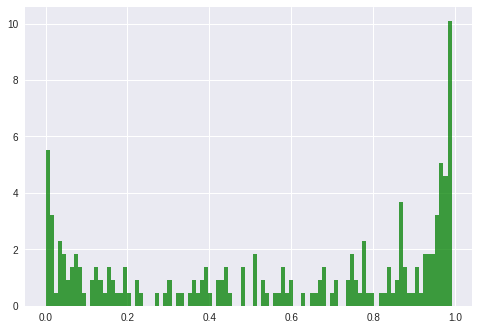

In [29]:
# click=1 prediction as click = =1 probabilities
click1=prob_click_val[Y_click_val[:,1].astype(bool),1]
# the histogram of the data
n, bins, patches = plt.hist(click1, 100, normed=True, facecolor='g', alpha=0.75)
# for item in patches:
#     item.set_height(item.get_height()/sum(n))

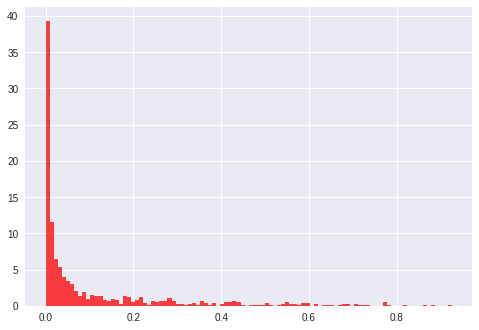

In [30]:
# click=0 prediction as click=1 probabilities
click0=prob_click_val[Y_click_val[:,0].astype(bool),1]
# the histogram of the data
n, bins, patches = plt.hist(click0, 100, normed=True, facecolor='r', alpha=0.75)
# for item in patches:
#     item.set_height(item.get_height()/sum(n))

In [31]:
# # just pick whichever prob is higher as prediction
# pred_click_train=(prob_click_train == prob_click_train.max(axis=1, keepdims=True)).astype(int)
# pred_click_val=(prob_click_val == prob_click_val.max(axis=1, keepdims=True)).astype(int)
# pred_1_click_train=pred_click_train[:,1]
# pred_1_click_val=pred_click_val[:,1]

# Pick pred_threshold for click=1 as click=1
pred_threshold=0.4
pred_1_click_train=np.greater_equal(prob_click_train[:,1],pred_threshold).astype(int)
pred_1_click_val=np.greater_equal(prob_click_val[:,1],pred_threshold).astype(int)

# Gold 
Y_1_click_train =Y_click_train[:,1]
Y_1_click_val =Y_click_val[:,1]



In [32]:
click_eval=ClickEvaluator()

In [33]:
#Train
click_precision,click_recall,click_f1score=\
    click_eval.printClickPredictionScore(y_Pred=pred_1_click_train,y_Gold=Y_1_click_train)

Number of 1 in pred:  1898
Number of 0 in pred:  8032
Number of 1 in gold:  1986
Number of 0 in gold:  7944
Click=0 	Precision\pCTR: 0.948 	Recall: 0.959 	F1: 0.953
Click=1 	Precision\pCTR: 0.827 	Recall: 0.790 	F1: 0.808


In [34]:
#Validation
click_precision,click_recall,click_f1score=\
    click_eval.printClickPredictionScore(y_Pred=pred_1_click_val,y_Gold=Y_1_click_val)

Number of 1 in pred:  210
Number of 0 in pred:  890
Number of 1 in gold:  220
Number of 0 in gold:  880
Click=0 	Precision\pCTR: 0.910 	Recall: 0.920 	F1: 0.915
Click=1 	Precision\pCTR: 0.667 	Recall: 0.636 	F1: 0.651


In [35]:
# Plot data https://vkolachalama.blogspot.co.uk/2016/05/keras-implementation-of-mlp-neural.html
def roc_results_plot(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    
    plt.show()
    print('AUC: %f' % roc_auc)

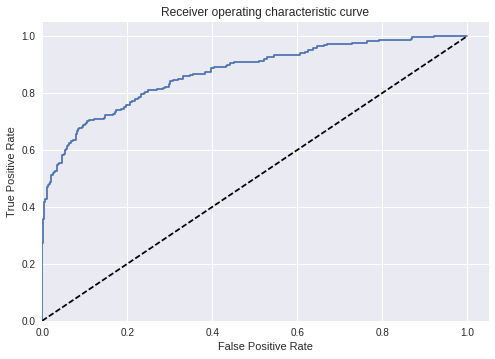

AUC: 0.870010


In [36]:
roc_results_plot(Y_click_val[:,1],prob_click_val[:,1])

# Bid Prediction

In [37]:
def format_bids_output(bids,bidid_pd_dataset):
    bidid_pd_dataset['bidprice']=bids
    return bidid_pd_dataset

In [38]:
def compute_avgCTR(clicks_dataset):
    avgCTR = clicks_dataset.sum()/len(clicks_dataset)
    return avgCTR

In [39]:
def compute_bids(reserve,Y,prob_clicks,pred_clicks,budget,prune_thresh,budget_thresh,pred_payprice_val):
    print('dataset size                   : {}'.format(len(pred_clicks)))
    print('actual budget                  : {}'.format(int(budget)))
    print('budget with overflow {}x       : {}'.format(budget_thresh,int(budget*budget_thresh)))
    avgCTR = compute_avgCTR(pred_clicks)
    print('base price                     : {}'.format(round(BASE_PRICE,1)))
    print('avgCTR                         : {}'.format(round(avgCTR,5)))
    
    #initial_bids = BASE_PRICE*(prob_clicks/avgCTR) #base_price*(pCTR/avgCTR) formula
    initial_bids = pred_payprice_val*BASE_PRICE
    #print(initial_bids)
    print('inital bid total               : {}'.format(int(initial_bids.sum())))
    
    ## only bid if we are above min of slotprice
    bids_reserve_price_met=np.ma.masked_less(initial_bids,reserve) # mask out values less than
    np.ma.set_fill_value(bids_reserve_price_met, 0.0)
    #print(bids_reserve_price_met.filled()) # return with filled value i.e masked out values become 0
    print('bid total post-reserve prune   : {}'.format(int(bids_reserve_price_met.filled().sum())))
    
    ## ensure we are below budget too, do crude pruning based on pred prob
    prune_tresh_mask=np.less(prob_clicks,prune_thresh)
    #print(prune_tresh_mask)
    bids_click_thresh_mask=np.ma.masked_array(bids_reserve_price_met.filled(),prune_tresh_mask)
    np.ma.set_fill_value(bids_click_thresh_mask, 0.0)
    #print(bids_click_thresh_mask.filled()) # return with filled value i.e masked out values become 0    
    print('bid total post-prob {} prune  : {}'.format(prune_thresh,int(bids_click_thresh_mask.filled().sum())))    
    
    ## ensure we are below budget too, further pruning until under budget
    bids_ma=bids_click_thresh_mask
    #print(bids_ma.mask)
    #work backwards until we are within budget
    i=-1
    while int(bids_ma.filled().sum()) > budget*budget_thresh:
        #print("{},{},{}".format(i,int(bids_ma.filled().sum()),budget))
        bids_ma.mask[i] = True
        i+=-1
    #print(bids_ma.filled()) # return with filled value i.e masked out values become 0    
    print('bid total backwards {} prune : {}'.format(-i-1,int(bids_ma.filled().sum())))    
    
    return bids_ma.filled().astype(int)

In [40]:
# on Train
print("True Train CTR: {}".format(compute_avgCTR(Y_1_click_train)))
print("Pred Train CTR: {}".format(compute_avgCTR(pred_1_click_train)))

True Train CTR: 0.2
Pred Train CTR: 0.19113796576032224


In [41]:
# on Validation
print("True Validation CTR: {}".format(compute_avgCTR(Y_1_click_val)))
print("Pred Validation CTR: {}".format(compute_avgCTR(pred_1_click_val)))

True Validation CTR: 0.2
Pred Validation CTR: 0.19090909090909092


In [42]:
#prob_click_val[:,1]

In [43]:
### TODO THOUGHTS on improving bid strategy:
# Use the no click distribution mean prob to set prune_tresh?
# base_price considerations = best opt for ratio of pred_click=1 wins?

In [44]:
### Validation set
BASE_PRICE=150#95#95#160#150#92#200#100
prune_thresh=0.4#0.15#0.2
budget_thresh=8#2.8
#budget=int(25000*1000/(299749*0.00075))*0.2*1100
budget=int(104.83*220) #this is avg payprice for true click=1
#Training true CTR ratio 0.00075
#0    2695704
#1       2034
#Total 2697738
reserve_val=validationData['slotprice'].as_matrix().astype(int)
bids=compute_bids(reserve_val,Y_val,prob_click_val[:,1],pred_1_click_val,budget,prune_thresh,budget_thresh,pred_payprice_val)
#format bids
bidids_pd_val=validationData[['bidid']].copy()
est_bids_df=format_bids_output(bids,bidids_pd_val)

dataset size                   : 1100
actual budget                  : 23062
budget with overflow 8x       : 184496
base price                     : 150
avgCTR                         : 0.19091
inital bid total               : 1358700
bid total post-reserve prune   : 1358700
bid total post-prob 0.4 prune  : 218850
bid total backwards 224 prune : 184050


In [45]:
#est_bids_df.shape
#validationData[['bidid']] #5efc19765061bab7f833658e9da87da7
#est_bids_df
#validationData[['bidid','click','payprice']].set_index('bidid').join(est_bids_df.set_index('bidid'))
joinedData=validationData[['bidid','click','payprice']].set_index('bidid').join(est_bids_df.set_index('bidid'))
joinedData[joinedData['click'] == 1 ]
#joinedData[(joinedData['bidprice'] >= joinedData['payprice']) & (joinedData['click'] == 1)]
joinedData[(joinedData['bidprice'] < joinedData['payprice']) & (joinedData['click'] == 1)]

,click,payprice,bidprice
bidid,,,
d874289e1f2da462b8fa861230f85637,1,250,0
f2b10f4ba55e06d4ea84f4fea8bb62f2,1,80,0
3c86d57dd55cc734762cda717358dec6,1,201,0
5363c65223cc2dccdceacf1d2ccd5489,1,59,0
8aa4c15445aad277d920f34a888648c3,1,181,0
d47f05d43b7b684f5be4065c6a9886c9,1,99,0
bde1a6e472d001aa7945f698e8288a7b,1,205,0
c56948c1aba3432e264361635ebf66e7,1,80,0
8163908fd73fa5cf4c4ad374967d42e6,1,230,0


In [46]:
myEvaluator = Evaluator()
myEvaluator.computePerformanceMetricsDF(budget, est_bids_df, validationData,verbose=True)
myEvaluator.printResult()

#### FLAWED: these didn't account for difference in true CTR due to rebalance of classes
## Unlimited budget
# Metrics compute time: 0.01 seconds
# Trimmed Bids: 0
# Won:  1100
# Click:  220
# CTR:  0.2
# CPM:  87187.2727273
# Spend:  95906
# Average CPC:  435.936363636

## maximise click capture
# dataset size                   : 1100
# actual budget                  : 91743
# budget with overflow 50x       : 4587150
# base price                     : 800
# avgCTR                         : 0.19545
# inital bid total               : 1323993
# bid total post-reserve prune   : 1323935
# bid total post-prob 0.02 prune  : 1322750
# bid total backwards 0 prune : 1322750
# Metrics compute time: 0.01 seconds
# Trimmed Bids: 0
# Won:  1062
# Click:  219
# CTR:  0.206214689266
# CPM:  86059.3220339
# Spend:  91395
# Average CPC:  417.328767123

#### new
# dataset size                   : 1100
# actual budget                  : 104830
# budget with overflow 1.2x       : 125796
# base price                     : 92
# avgCTR                         : 0.19545
# inital bid total               : 152259
# bid total post-reserve prune   : 148268
# bid total post-prob 0.3 prune  : 106980
# bid total backwards 0 prune : 106980
# Metrics compute time: 0.01 seconds
# Trimmed Bids: 0
# Won:  376
# Click:  163
# CTR:  0.433510638298
# CPM:  92194.1489362
# Spend:  34665
# Average CPC:  212.668711656

### new 2
# dataset size                   : 1100
# actual budget                  : 23062
# budget with overflow 2.8x       : 64573
# base price                     : 135
# avgCTR                         : 0.55545
# inital bid total               : 80093
# bid total post-reserve prune   : 72663
# bid total post-prob 0.18 prune  : 64913
# bid total backwards 8 prune : 64569
# Metrics compute time: 0.01 seconds
# Trimmed Bids: 7
# Won:  379
# Click:  139
# CTR:  0.366754617414
# CPM:  60778.3641161
# Spend:  23035
# Average CPC:  165.71942446

Metrics compute time: 0.0 seconds
Trimmed Bids: 0
Won:  178
Click:  120
CTR:  0.674157303371
CPM:  106882.022472
Spend:  19025
Average CPC:  158.541666667


In [47]:
# myEvaluator = Evaluator()
# myEvaluator.computePerformanceMetricsDF(budget, est_bids_df, validationData)
# myEvaluator.printResult()

In [48]:
myEvaluator.resultDict

{'click': 120, 'spend': 19025, 'trimmed_bids': 0, 'won': 178}